<a href="https://colab.research.google.com/github/deshanchathusanka/Attention-Gated-Networks/blob/master/satellite_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.&nbsp;$\color{Blue}{\text{Initial Setup}}$

## 1.1&nbsp;Package Installation
*   GPU accelerated image processing libraries (cupy)

In [ ]:
!pip install -U cython # C-extention for Python
!pip install rioxarray
!curl https://colab.chainer.org/install | sh -
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install webcolors
!pip install netron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.3 MB 7.6 MB/s 
     |████████████████████████████████| 19.3 MB 14.2 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=9745c5b2d00ef9f6dea1a9e3b50110863c9513e5faa8b9f4761e846f43085278
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  10675      0 --:--:--

## 1.2&nbsp;Mount Google Drive

In [113]:
!rm -f data
!rm -rf results
!mkdir results
!mkdir results/train
!mkdir results/test
!mkdir results/train/original
!mkdir results/train/predicted
!mkdir results/train/reconstructed
!mkdir results/test/original
!mkdir results/test/predicted
!mkdir results/test/reconstructed

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ln -s "/content/drive/My Drive/MS Project/program/data"

Mounted at /content/drive


## 1.3&nbsp;Import Statements

In [ ]:
import os
import pdb
import math
import cupy as cp # GPU-accelerated programming
import time
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import glob
from scipy.spatial import KDTree
from webcolors import (
    CSS3_HEX_TO_NAMES,
    hex_to_rgb,
)
from natsort import natsorted

from PIL import Image, ImageEnhance # Pillow 
import cv2 # Open CV
import re # Regex Package
import pandas as pd



############## machine learning packages ###############
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
from torchsummary import summary
import torchvision.transforms as transforms

from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy import ndimage, misc

# 2.&nbsp;$\color{Blue}{\text{Dataset Analysis}}$

## 2.1&nbsp;RGB Image Analysis


### 2.1.1&nbsp;Read Image

<class 'numpy.ndarray'>


<Figure size 432x288 with 0 Axes>

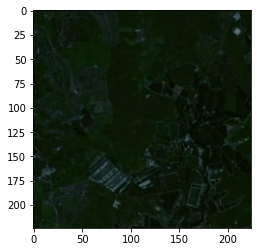

Shape of Image: (224, 224, 3)


In [ ]:
numpy_image = cv2.imread(filename = 'data/images/train/farm20.png') 
print(type(numpy_image))

plt.figure()
plt.show('Original Image')
plt.imshow(numpy_image)
plt.show()

print(f'Shape of Image: {numpy_image.shape}')

### 2.1.2&nbsp;Normalisation

#### 2.1.2.1&nbsp;Cumulative Count Cut 

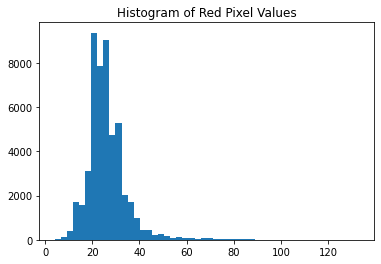

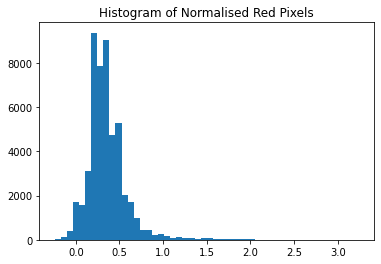

<Figure size 432x288 with 0 Axes>

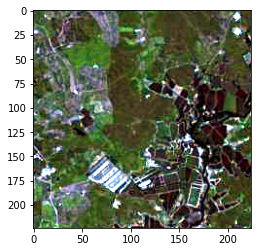

In [ ]:
########################## cumulative count cut normalisation #######################################
def cum_cnt_cut_norm(x):
  return((x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x,2)))

#### split rgb bands ####
numpy_image = cv2.imread(filename = 'data/images/train/farm20.png') 
red_band = numpy_image[:,:,0]
green_band = numpy_image[:,:,1]
blue_band = numpy_image[:,:,2]

#### plot histogram ####
plt.figure()
plt.title(label='Histogram of Red Pixel Values')
plt.hist(green_band.ravel(), bins = 50)
plt.show()

#### Cumulative Count Cut Normalisation ####
red_normalised = cum_cnt_cut_norm(red_band)
green_normalised = cum_cnt_cut_norm(green_band)
blue_normalised = cum_cnt_cut_norm(blue_band)

#### plot histogram ####
plt.figure()
plt.title(label='Histogram of Normalised Red Pixels')
plt.hist(green_normalised.ravel(), bins = 50)
plt.show()

rgb_values = np.dstack((red_normalised, green_normalised, blue_normalised))
plt.figure()
plt.show('Original Image With Cumulative Count Cut')
plt.imshow(rgb_values)
plt.show()

<Figure size 432x288 with 0 Axes>

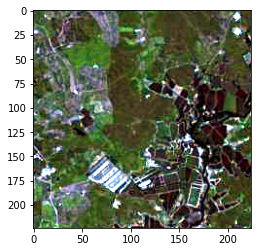

In [ ]:
def normalize_rgb(numpy_image):
  #### split rgb bands ####
  red_band = numpy_image[:,:,0]
  green_band = numpy_image[:,:,1]
  blue_band = numpy_image[:,:,2]

  #### Cumulative Count Cut Normalisation ####
  red_normalised = cum_cnt_cut_norm(red_band)
  green_normalised = cum_cnt_cut_norm(green_band)
  blue_normalised = cum_cnt_cut_norm(blue_band)

  rgb_values = np.dstack((red_normalised, green_normalised, blue_normalised))
  return rgb_values

normalised_image = normalize_rgb(numpy_image)
plt.figure()
plt.show('Original Image With Cumulative Count Cut')
plt.imshow(normalised_image)
plt.show()

#### 2.1.2.2&nbsp;Standard Normal Distribution

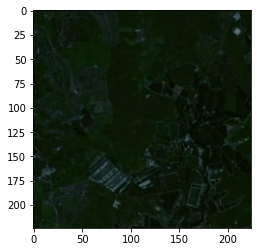

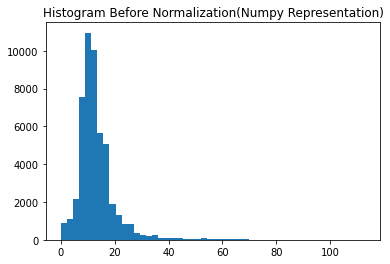

(224, 224, 3)
torch.Size([3, 224, 224])


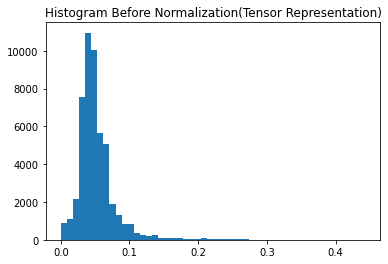


tensor([0.0523, 0.1026, 0.0460]) tensor([0.0291, 0.0339, 0.0426])


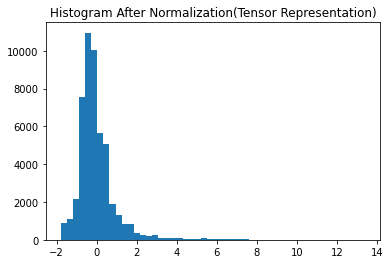

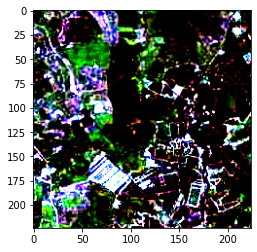

In [ ]:
import torchvision.transforms as transforms

plt.imshow(numpy_image)

plt.figure()
plt.title(label='Histogram Before Normalization(Numpy Representation)')
plt.hist(numpy_image[:,:,0].ravel(), bins = 50)
plt.show()

print(numpy_image.shape)
transform = transforms.ToTensor()
tensor_image = transform(numpy_image)
print(tensor_image.shape)

plt.figure()
plt.title(label='Histogram Before Normalization(Tensor Representation)')
plt.hist(tensor_image[0].ravel(), bins = 50)
plt.show()

print()
mean, std = tensor_image.mean(dim = [1,2]), tensor_image.std(dim = [1,2])
print(mean, std)

transform_norm = transforms.Normalize(mean, std)
normalised_image = transform_norm(tensor_image)

plt.figure()
plt.title(label='Histogram After Normalization(Tensor Representation)')
plt.hist(normalised_image[0].ravel(), bins = 50)
plt.show()

normalised_image_np = np.array(normalised_image)
normalised_image_np = normalised_image_np.transpose(1,2,0)
plt.imshow(normalised_image_np)




### 2.1.3&nbsp;Histogram Equalisation

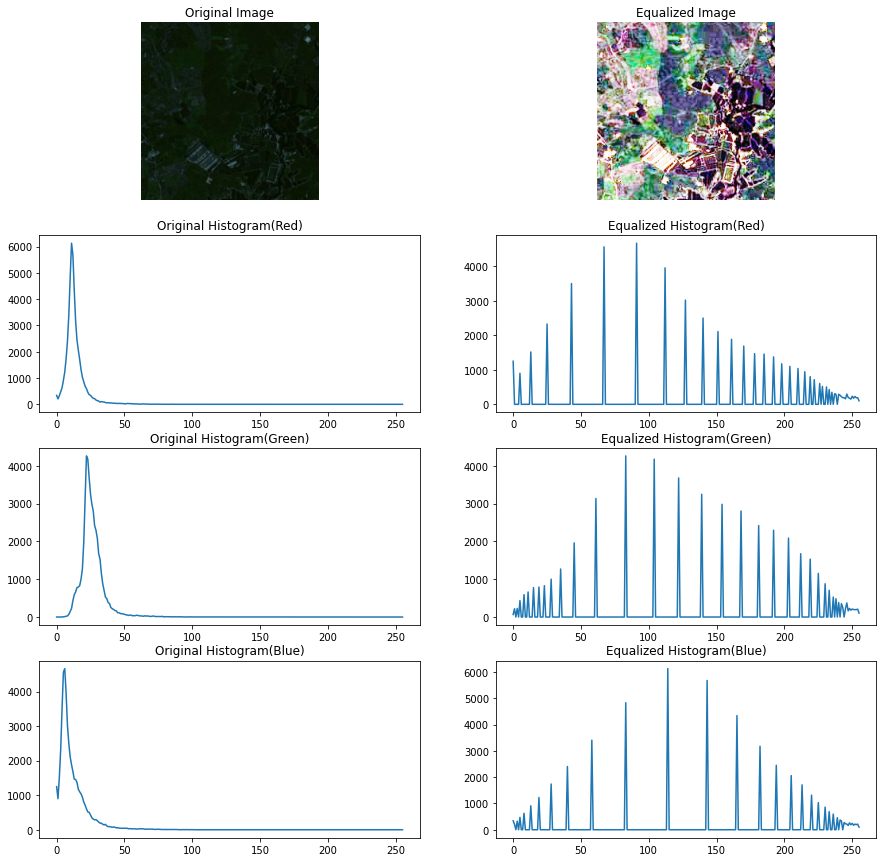

In [ ]:
def equalize(numpy_image):
  # convert image from one color space into another
  rgb_image = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2RGB) 

  # split RGB channels
  r_image, g_image, b_image = cv2.split(rgb_image)

  # equalize RGb channels
  r_image_eq = cv2.equalizeHist(r_image)
  g_image_eq = cv2.equalizeHist(g_image)
  b_image_eq = cv2.equalizeHist(b_image)

  # merge equalized channels
  eq_image = cv2.merge((r_image_eq, g_image_eq, b_image_eq))

  return eq_image

###################################
#          Test           #
###################################
eq_image = equalize(numpy_image)
fig = plt.figure(figsize = (15, 15))

###################################
#          Image                  #
###################################
ax1 = fig.add_subplot(4, 2, 1)
ax1.axis("off")
ax1.title.set_text('Original Image')
ax1.imshow(numpy_image)

ax2 = fig.add_subplot(4, 2, 2)
ax2.axis("off")
ax2.title.set_text("Equalized Image")
ax2.imshow(eq_image)

###################################
#          Red Histogram          #
###################################
original_hist = cv2.calcHist([numpy_image],[0], None, [256],[0,256]) # (images, channels, mask, bins, range)
ax3 = fig.add_subplot(4, 2, 3)
ax3.title.set_text("Original Histogram(Red)")
ax3.plot(original_hist)

eq_hist = cv2.calcHist([eq_image],[0], None, [256],[0,256]) # (images, channels, mask, bins, range)
ax4 = fig.add_subplot(4, 2, 4)
ax4.title.set_text("Equalized Histogram(Red)")
ax4.plot(eq_hist)

###################################
#          Green Histogram        #
###################################
original_hist = cv2.calcHist([numpy_image],[1], None, [256],[0,256]) # (images, channels, mask, bins, range)
ax5 = fig.add_subplot(4, 2, 5)
ax5.title.set_text("Original Histogram(Green)")
ax5.plot(original_hist)

eq_hist = cv2.calcHist([eq_image],[1], None, [256],[0,256]) # (images, channels, mask, bins, range)
ax6 = fig.add_subplot(4, 2, 6)
ax6.title.set_text("Equalized Histogram(Green)")
ax6.plot(eq_hist)

###################################
#          Blue Histogram         #
###################################
original_hist = cv2.calcHist([numpy_image],[2], None, [256],[0,256]) # (images, channels, mask, bins, range)
ax7 = fig.add_subplot(4, 2, 7)
ax7.title.set_text("Original Histogram(Blue)")
ax7.plot(original_hist)

eq_hist = cv2.calcHist([eq_image],[2], None, [256],[0,256]) # (images, channels, mask, bins, range)
ax8 = fig.add_subplot(4, 2, 8)
ax8.title.set_text("Equalized Histogram(Blue)")
ax8.plot(eq_hist)


### 2.1.4&nbsp;Brightness and Contrast Enhancement

*   Brightness : Luminosity Level
*   Contrast : Difference in brightness between objects




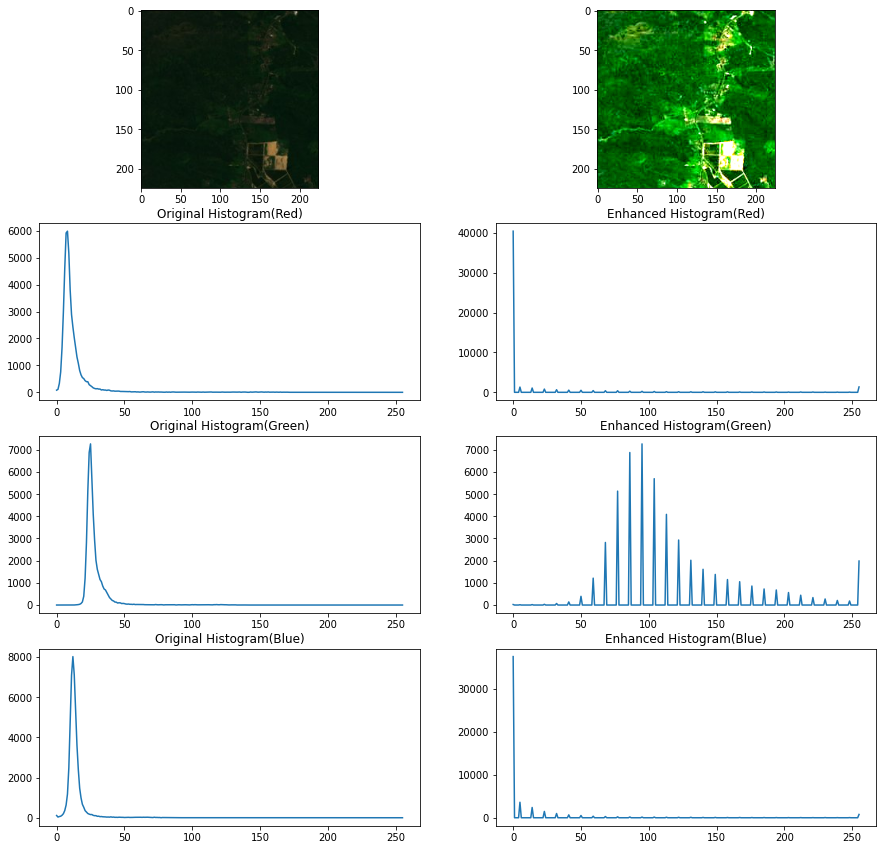

In [ ]:
def image_enhance(img, bright_factor, contrast_factor):
  bright_filter = ImageEnhance.Brightness(img)
  enh_img = bright_filter.enhance(bright_factor)
  contrast_filter = ImageEnhance.Contrast(enh_img)
  enh_img = contrast_filter.enhance(contrast_factor)
  enh_img_np = np.array(enh_img)
  return enh_img_np

fig = plt.figure(figsize = (15, 15))

###################################
#          Image                  #
###################################
img = Image.open(fp = 'data/images/train/farm26.png')
ax1 = fig.add_subplot(4,2,1)
ax1.imshow(img)
img_np = np.array(img)

enh_img_np = image_enhance(img, 3, 3)
ax2 = fig.add_subplot(4,2,2)
ax2.imshow(enh_img_np)

###################################
#          Red Histogram          #
###################################
original_hist = cv2.calcHist([img_np],[0], None, [256],[0,256]) # (images, channels, mask, bins, range)
ax3 = fig.add_subplot(4, 2, 3)
ax3.title.set_text("Original Histogram(Red)")
ax3.plot(original_hist)

eq_hist = cv2.calcHist([enh_img_np],[0], None, [256],[0,256]) # (images, channels, mask, bins, range)
ax4 = fig.add_subplot(4, 2, 4)
ax4.title.set_text("Enhanced Histogram(Red)")
ax4.plot(eq_hist)

###################################
#          Green Histogram        #
###################################
original_hist = cv2.calcHist([img_np],[1], None, [256],[0,256]) # (images, channels, mask, bins, range)
ax5 = fig.add_subplot(4, 2, 5)
ax5.title.set_text("Original Histogram(Green)")
ax5.plot(original_hist)

eq_hist = cv2.calcHist([enh_img_np],[1], None, [256],[0,256]) # (images, channels, mask, bins, range)
ax6 = fig.add_subplot(4, 2, 6)
ax6.title.set_text("Enhanced Histogram(Green)")
ax6.plot(eq_hist)

###################################
#          Blue Histogram         #
###################################
original_hist = cv2.calcHist([img_np],[2], None, [256],[0,256]) # (images, channels, mask, bins, range)
ax7 = fig.add_subplot(4, 2, 7)
ax7.title.set_text("Original Histogram(Blue)")
ax7.plot(original_hist)

eq_hist = cv2.calcHist([enh_img_np],[2], None, [256],[0,256]) # (images, channels, mask, bins, range)
ax8 = fig.add_subplot(4, 2, 8)
ax8.title.set_text("Enhanced Histogram(Blue)")
ax8.plot(eq_hist)



### 2.1.5&nbsp;Smoothing and Noise Removal

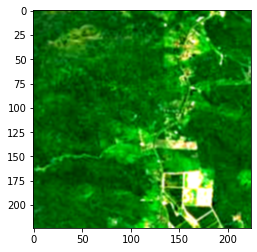

In [ ]:
img = Image.open(fp = 'data/images/train/farm26.png')
enh_img_np = image_enhance(img, 3, 3)
lpf_image = cv2.GaussianBlur(enh_img_np,(3,3),0)
plt.imshow(lpf_image)

## 2.2&nbsp;Multispectral Image Analysis

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'cube'])
(224, 224, 7, 72)


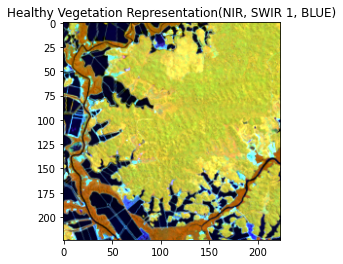

(224, 224, 3)


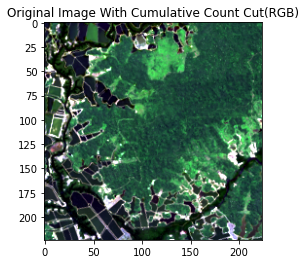

In [ ]:
mat = scipy.io.loadmat('data/images/cube.mat') 
print(type(mat))
print(mat.keys())

mul_img_data = mat['cube']
print(mul_img_data.shape) #### There are seven channels ####
 
#### split bands ####
image_index = 71
ultra_blue_band = mul_img_data[:,:,0,image_index]
blue_band = mul_img_data[:,:,1,image_index]
green_band = mul_img_data[:,:,2,image_index]
red_band = mul_img_data[:,:,3,image_index]
nir_band = mul_img_data[:,:,4,image_index]
swir_1_band = mul_img_data[:,:,5,image_index]
swir_2_band = mul_img_data[:,:,6,image_index]

#### Cumulative Count Cut Normalisation ####
red_normalised = cum_cnt_cut_norm(red_band)
green_normalised = cum_cnt_cut_norm(green_band)
blue_normalised = cum_cnt_cut_norm(blue_band)
nir_normalised = cum_cnt_cut_norm(nir_band)
swir_1_normalised = cum_cnt_cut_norm(swir_1_band)
swir_2_normalised = cum_cnt_cut_norm(swir_2_band)

# rns_values = np.dstack((swir_1_band, nir_band, blue_band))
# enh_img_np = image_enhance(img, 3, 3)
# plt.figure()
# plt.title('Original Image With Cumulative Count Cut(SWIR 1, NIR, BLUE)')
# plt.imshow(rns_values)
# plt.show()

healthy_band_cmb = np.dstack((nir_normalised, swir_1_normalised, blue_normalised))
# enh_img_np = image_enhance(healthy_band_cmb, 3, 3)
plt.figure()
plt.title('Healthy Vegetation Representation(NIR, SWIR 1, BLUE)')
plt.imshow(healthy_band_cmb)
plt.show()

rgb_band_cmb = np.dstack((red_normalised, green_normalised, blue_normalised))
print(rgb_band_cmb.shape)
plt.figure()
plt.title('Original Image With Cumulative Count Cut(RGB)')
plt.imshow(rgb_band_cmb)
plt.show()

## 2.3&nbsp;Generate Binary Ground Truth Images

In [ ]:
def convert_rgb_to_names(rgb_tuple):
    css3_db = CSS3_HEX_TO_NAMES
    names = []
    rgb_values = []
    for color_hex, color_name in css3_db.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color_hex))
    
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple)
    return f'closest match: {names[index]}'


im = cv2.imread('data/sortLabel_RGB/Labeln_01.png') 
for label in np.unique(im.reshape(-1, im.shape[2]), axis = 0):
  rgb_combination = label.astype(int)
  print(rgb_combination)
  print(convert_rgb_to_names(rgb_combination))
print()


for filename in glob.glob('data/sortLabel_RGB/*.png'): 
  masked_img_name = filename.split(sep='_')[2]
  farm_rgb = [128, 255, 128]

  # Load image
  image = cv2.imread(filename)

  # Mask of white pixels - elements are True where image is White
  farm_mask = (image == farm_rgb).all(axis = 2) 

  farm_mask = np.expand_dims(a = farm_mask, axis = 2)
  farm_mask = np.repeat(farm_mask, 3, axis=2)

  # Save as PNG
  cv2.imwrite('data/binary_label_original/' + masked_img_name, (farm_mask*255).astype(np.uint8))    

[0 0 0]
closest match: black
[  0   0 255]
closest match: blue
[  0 128   0]
closest match: green
[  0 128 128]
closest match: teal
[128  64  64]
closest match: sienna
[128 255 128]
closest match: lightgreen
[255 128 255]
closest match: violet



# 3&nbsp;$\color{Blue}{\text{RGB Implementation}}$

## 3.1&nbsp;Architecture Diagram

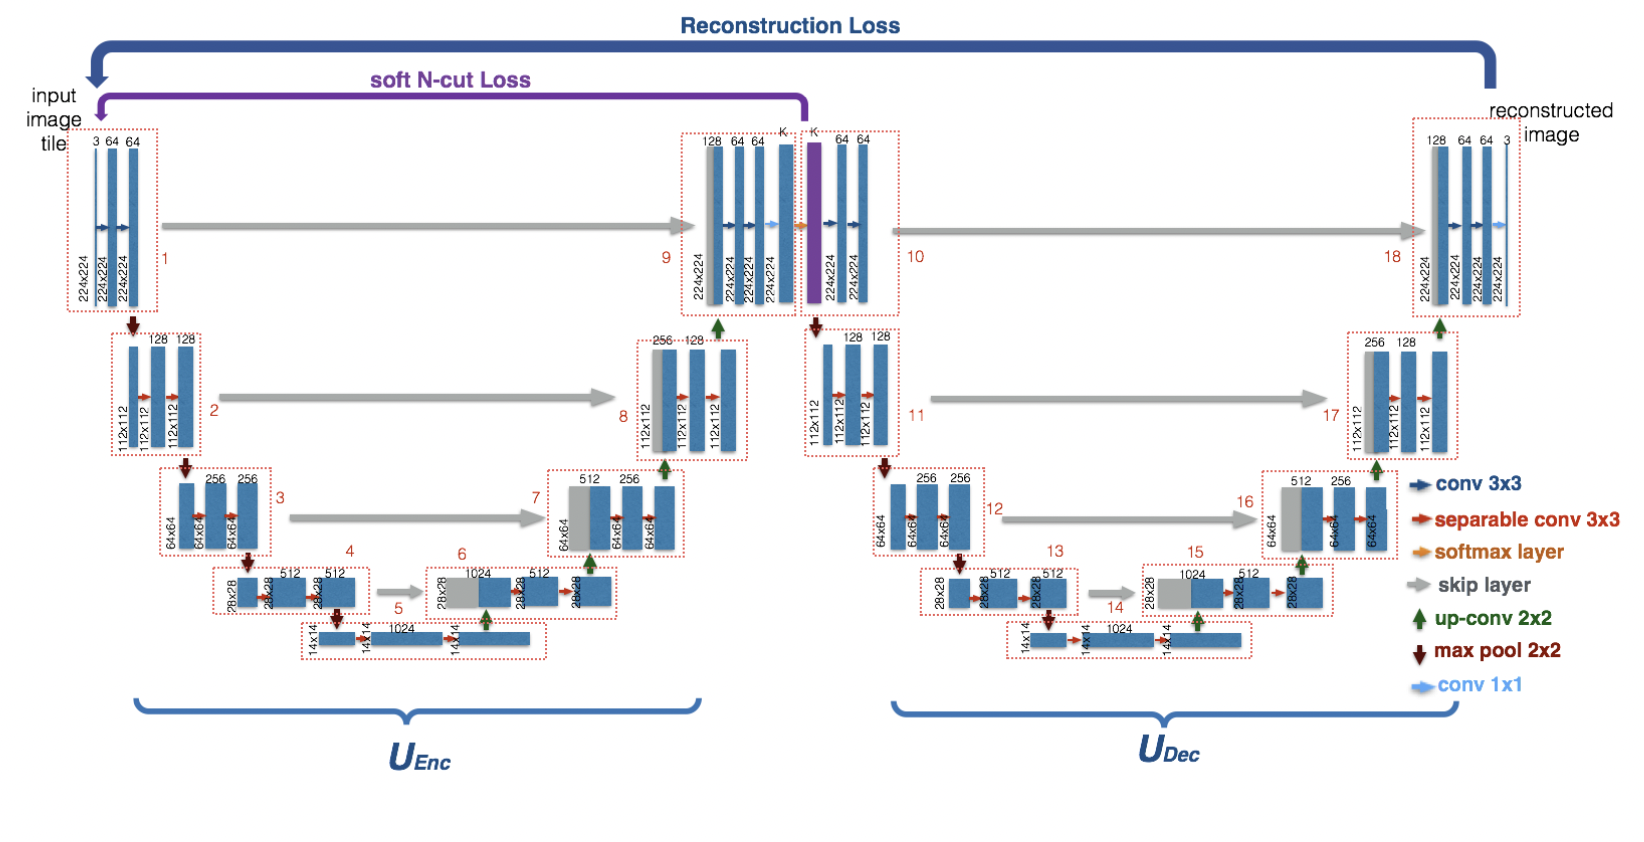

## 3.2&nbsp;Configuration

In [81]:
class Config():
  def __init__(self):
    self.debug = True
    self.input_size = 96 # Side length of square image patch
    self.batch_size = 1 # Batch size of patches Note: 11 gig gpu will max batch of 5
    self.val_batch_size = 4 # Number of images shown in progress
    self.test_batch_size = 1 # We only use the first part of the model here (forward_encoder), so it can be larger
    self.verbose_testing = False

    self.k = 2 # Number of classes
    self.num_epochs = 5 #250 for real
    self.data_dir = "./data/" # Directory of images
    self.showdata = False # Debug the data augmentation by showing the data we're training on.

    self.useInstanceNorm = True # Instance Normalization
    self.useBatchNorm = False # Only use one of either instance or batch norm
    self.useDropout = False
    self.drop = 0.2

    # Each item in the following list specifies a module.
    # Each item is the number of input channels to the module.
    # The number of output channels is 2x in the encoder, x/2 in the decoder.
    self.chNum = [64, 128, 256, 512, 1024, 2048]

    self.showSegmentationProgress = True
    self.segmentationProgressDir = './latent_images/'

    self.variationalTranslation = 0 # Pixels, 0 for off. 1 works fine

    self.saveModel = True



## 3.3&nbsp;Model 

### 3.3.1&nbsp;Attention Gate 

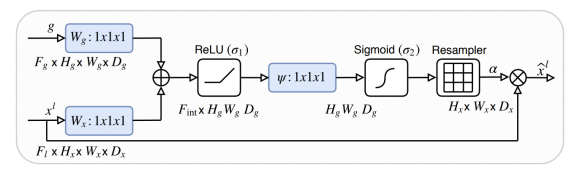

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        self.F_g = F_g # gating signal
        self.F_l = F_l # skip connection
        self.F_int = F_int 
        super(Attention_block,self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size = 1,stride = 1,padding = 0,bias = True),
            nn.InstanceNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size = 1,stride = 2,padding = 0,bias = True),
            nn.InstanceNorm2d(F_int) 
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size = 1,stride = 1,padding = 0,bias = True),
            nn.InstanceNorm2d(1),
            nn.Sigmoid()
        )

        self.upsample = nn.UpsamplingBilinear2d(scale_factor = 2)
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g+x1)
        psi = self.psi(psi)

        up_psi = self.upsample(psi)

        return x*up_psi

### 3.3.2&nbsp;W-net Model

#### 3.3.2.1 &nbsp;Convolution Block

In [84]:
config = Config()

''' Each module consists of two 3 x 3 conv layers, each followed by a ReLU
non-linearity and batch normalization.

In the expansive path, modules are connected via transposed 2D convolution
layers.

The input of each module in the contracting path is also bypassed to the
output of its corresponding module in the expansive path

we double the number of feature channels at each downsampling step
We halve the number of feature channels at each upsampling step

'''

# NOTE: batch norm is up for debate
# We want batch norm if possible, but the batch size is too low to benefit
# So instead we do instancenorm

# Note: Normalization should go before ReLU

# Padding=1 because (3x3) conv leaves of 2pixels in each dimension, 1 on each side
# Do we want non-linearity between pointwise and depthwise (separable) conv?
# Do we want non-linearity after upconv?

class ConvModule(nn.Module):
    def __init__(self, input_dim, output_dim, seperable = True, cnn_blocks = 2):
        super(ConvModule, self).__init__()

        if seperable:
          layers = [
              ########### layer block 1 #############
              nn.Conv2d(input_dim, output_dim, kernel_size = 1), # Pointwise (1x1) through all channels
              nn.Conv2d(output_dim, output_dim, kernel_size = 3, padding = 1, groups = output_dim), # Depthwise (3x3) through each channel
              nn.InstanceNorm2d(output_dim),
              nn.BatchNorm2d(output_dim),
              nn.ReLU(),
              nn.Dropout(config.drop)
          ]

          for i in range(1, cnn_blocks):
            ########### layer block 2 #############
            layers.append(nn.Conv2d(output_dim, output_dim, kernel_size = 1))
            layers.append(nn.Conv2d(output_dim, output_dim, kernel_size = 3, padding = 1, groups = output_dim))
            layers.append(nn.InstanceNorm2d(output_dim))
            layers.append(nn.BatchNorm2d(output_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(config.drop))
          
        else:
          layers = [
              ########### layer block 1 #############
              nn.Conv2d(in_channels = input_dim, out_channels = output_dim, kernel_size = 3, padding = 1),
              nn.InstanceNorm2d(64),
              nn.BatchNorm2d(64),
              nn.ReLU(),
              nn.Dropout(config.drop)
          ]

          for layer in range(1, cnn_blocks):
            ########### layer block 2 #############
            layers.append(nn.Conv2d(in_channels = output_dim, out_channels = output_dim, kernel_size = 3, padding = 1))
            layers.append(nn.InstanceNorm2d(64))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(config.drop))
          
        if not config.useInstanceNorm:
            layers = [layer for layer in layers if not isinstance(layer, nn.InstanceNorm2d)]
        if not config.useBatchNorm:
            layers = [layer for layer in layers if not isinstance(layer, nn.BatchNorm2d)]
        if not config.useDropout:
            layers = [layer for layer in layers if not isinstance(layer, nn.Dropout)]

        self.module = nn.Sequential(*layers)

    def forward(self, x):
        return self.module(x)

#### 3.3.2.2 &nbsp;Model 01

In [ ]:
# ###################################
# #             Model 01            #
# ###################################
# class UNet(nn.Module): 

#     def __init__(self, 
#       input_channels = 3,
#       chNum = [64, 128, 256, 512, 1024],
#       output_channels = config.k):

#         super(UNet, self).__init__()
#         self.pool = nn.MaxPool2d(2, 2)

#         ######### module 1 ###########
#         self.first_module = ConvModule(input_dim = input_channels, output_dim = chNum[0], seperable = False)
      
#         ######### module 2 to module 5 ##############
#         self.enc_modules = nn.ModuleList()
#         for index in range(1, 5):
#           module = ConvModule(input_dim = chNum[index-1], output_dim = chNum[index])
#           self.enc_modules.append(module)

#         ######### module 6 to module 9 ##############
#         self.dec_modules = nn.ModuleList()
#         self.attention_modules = nn.ModuleList()
#         for index in range(4, 0, -1):
#           module = ConvModule(input_dim = chNum[index], output_dim = chNum[index-1])
#           self.dec_modules.append(module)

#           attention_module = Attention_block(F_g = chNum[index], F_l = chNum[index-1], F_int = chNum[index-1])
#           self.attention_modules.append(attention_module)

#         ######### prediction layer ###########
#         self.predconv = nn.Conv2d(64, output_channels, 1)

#         ######### up-sampling layers ##########
#         self.dec_transpose_layers = nn.ModuleList()
#         for i in range(4, 0, -1):
#             self.dec_transpose_layers.append(nn.ConvTranspose2d(chNum[i],chNum[i-1],kernel_size = 2, stride = 2,bias = True))
        
      
#     def forward(self, x):
#       ################# u-net encoder ##################
#       _x = self.first_module(x)
#       activations = [_x]

#       for module in self.enc_modules:
#         activation = module(self.pool(activations[-1]))
#         activations.append(activation)

#       ################# u-net decoder ##################
#       x_ = activations.pop(-1)
#       for conv, upconv, attention in zip(self.dec_modules, self.dec_transpose_layers, self.attention_modules):
#           skip_connection = activations.pop(-1)
#           # skip_connection = attention(x_, skip_connection)
#           x_ = conv(
#               torch.cat((skip_connection, upconv(x_)), 1)
#           )
          
#       segmentations = self.predconv(x_)
#       return segmentations


# class WNet(nn.Module):
#     def __init__(self, in_channels = 3):
#         super(WNet, self).__init__()

#         ############# w-net encoder ###############
#         self.U_encoder = UNet(input_channels = in_channels, output_channels = config.k)
#         self.softmax = nn.Softmax2d()

#         ############# w-net decoder ###############
#         self.U_decoder = UNet(input_channels = config.k, output_channels = in_channels)
#         self.sigmoid = nn.Sigmoid()

#     def forward_encoder(self, x):
#         encoder_output = self.U_encoder(x)
#         segmentations = self.softmax(encoder_output)
#         return segmentations

#     def forward_decoder(self, segmentations):
#         decoder_output = self.U_decoder(segmentations)
#         reconstructions = self.sigmoid(decoder_output)
#         return reconstructions

#     def forward(self, x): # x is (3 channels 224x224)
#         segmentations = self.forward_encoder(x)
#         x_prime       = self.forward_decoder(segmentations)
#         return segmentations, x_prime

#### 3.3.2.3 &nbsp;Model 02

In [ ]:
# ###################################
# #          Model 02 (VGG-16)      #
# ###################################
# class UNet(nn.Module): 

#     def __init__(self, 
#       input_channels = 3,
#       chNum = [64, 128, 256, 512, 1024],
#       output_channels = config.k):

#         super(UNet, self).__init__()
#         self.pool = nn.MaxPool2d(2, 2)

#         ###################################
#         #          UNet Enc               #
#         ###################################

#         ######### module 1 ###########
#         self.first_module = ConvModule(input_dim = input_channels, output_dim = chNum[0], seperable = False)
      
#         ######### module 2 ##############
#         self.enc_modules = nn.ModuleList()
#         self.enc_modules.append(ConvModule(input_dim = chNum[0], output_dim = chNum[1]))

#         ######### module 3 ##############
#         module = ConvModule(input_dim = chNum[1], output_dim = chNum[2], cnn_blocks = 3)
#         self.enc_modules.append(module)
        
#         ######### module 4 ##############
#         module = ConvModule(input_dim = chNum[2], output_dim = chNum[3], cnn_blocks = 6)
#         self.enc_modules.append(module)
        
#         ######### module 5 ##############
#         module = ConvModule(input_dim = chNum[3], output_dim = chNum[4], cnn_blocks = 3)
#         self.enc_modules.append(module)

#         ###################################
#         #          UNet Dec               #
#         ###################################
#         self.dec_modules = nn.ModuleList()
#         self.attention_modules = nn.ModuleList()
        
#         ######### module 6 ##############
#         module = ConvModule(input_dim = chNum[4], output_dim = chNum[3], cnn_blocks = 6)
#         self.dec_modules.append(module)

#         attention_module = Attention_block(F_g = chNum[4], F_l = chNum[3], F_int = chNum[3])
#         self.attention_modules.append(attention_module)
        
#         ######### module 7 ##############
#         module = ConvModule(input_dim = chNum[3], output_dim = chNum[2], cnn_blocks = 3)
#         self.dec_modules.append(module)

#         attention_module = Attention_block(F_g = chNum[3], F_l = chNum[2], F_int = chNum[2])
#         self.attention_modules.append(attention_module)

#         ######### module 8 to module 9 ##############
#         for index in range(2, 0, -1):
#           module = ConvModule(input_dim = chNum[index], output_dim = chNum[index-1])
#           self.dec_modules.append(module)

#           attention_module = Attention_block(F_g = chNum[index], F_l = chNum[index-1], F_int = chNum[index-1])
#           self.attention_modules.append(attention_module)

#         ######### prediction layer ###########
#         self.predconv = nn.Conv2d(64, output_channels, 1)

#         ######### up-sampling layers ##########
#         self.dec_transpose_layers = nn.ModuleList()
#         for i in range(4, 0, -1):
#             self.dec_transpose_layers.append(nn.ConvTranspose2d(chNum[i],chNum[i-1],kernel_size = 2, stride = 2,bias = True))
        
      
#     def forward(self, x):
#       ################# u-net encoder ##################
#       _x = self.first_module(x)
#       activations = [_x]

#       for module in self.enc_modules:
#         activation = module(self.pool(activations[-1]))
#         activations.append(activation)

#       ################# u-net decoder ##################
#       x_ = activations.pop(-1)
#       for conv, upconv, attention in zip(self.dec_modules, self.dec_transpose_layers, self.attention_modules):
#           skip_connection = activations.pop(-1)
#           # skip_connection = attention(x_, skip_connection)
#           x_ = conv(
#               torch.cat((skip_connection, upconv(x_)), 1)
#           )
          
#       segmentations = self.predconv(x_)
#       return segmentations


# class WNet(nn.Module):
#     def __init__(self, in_channels = 3):
#         super(WNet, self).__init__()

#         ############# w-net encoder ###############
#         self.U_encoder = UNet(input_channels = in_channels, output_channels = config.k)
#         self.softmax = nn.Softmax2d()

#         ############# w-net decoder ###############
#         self.U_decoder = UNet(input_channels = config.k, output_channels = in_channels)
#         self.sigmoid = nn.Sigmoid()

#     def forward_encoder(self, x):
#         encoder_output = self.U_encoder(x)
#         segmentations = self.softmax(encoder_output)
#         return segmentations

#     def forward_decoder(self, segmentations):
#         decoder_output = self.U_decoder(segmentations)
#         reconstructions = self.sigmoid(decoder_output)
#         return reconstructions

#     def forward(self, x): # x is (3 channels 224x224)
#         segmentations = self.forward_encoder(x)
#         x_prime       = self.forward_decoder(segmentations)
#         return segmentations, x_prime

#### 3.3.2.4 &nbsp;Model 03

In [ ]:
###################################
#             Model 03            #
###################################
class UNet(nn.Module): 

    def __init__(self, 
      input_channels = 3,
      chNum = [64, 128, 256, 512, 1024, 2048],
      output_channels = config.k):

        super(UNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        ######### module 1 ###########
        self.first_module = ConvModule(input_dim = input_channels, output_dim = chNum[0], seperable = False)
      
        ######### module 2 ##############
        self.enc_modules = nn.ModuleList()
        self.enc_modules.append(ConvModule(input_dim = chNum[0], output_dim = chNum[1]))

        ######### module 3 to module 5 ##############
        for index in range(2, 5):
          module = ConvModule(input_dim = chNum[index-1], output_dim = chNum[index], cnn_blocks = 3)
          self.enc_modules.append(module)
        
        ######### module 6 ##############
        module = ConvModule(input_dim = chNum[4], output_dim = chNum[5])
        self.enc_modules.append(module)

        ######### module 7 to module 9 ##############
        self.dec_modules = nn.ModuleList()
        self.attention_modules = nn.ModuleList()
        for index in range(5, 2, -1):
          module = ConvModule(input_dim = chNum[index], output_dim = chNum[index-1], cnn_blocks = 3)
          self.dec_modules.append(module)

          attention_module = Attention_block(F_g = chNum[index], F_l = chNum[index-1], F_int = chNum[index-1])
          self.attention_modules.append(attention_module)

        ######### module 10 to module 11 ##############
        for index in range(2, 0, -1):
          module = ConvModule(input_dim = chNum[index], output_dim = chNum[index-1])
          self.dec_modules.append(module)

          attention_module = Attention_block(F_g = chNum[index], F_l = chNum[index-1], F_int = chNum[index-1])
          self.attention_modules.append(attention_module)

        ######### prediction layer ###########
        self.predconv = nn.Conv2d(64, output_channels, 1)

        ######### up-sampling layers ##########
        self.dec_transpose_layers = nn.ModuleList()
        for i in range(5, 0, -1):
            self.dec_transpose_layers.append(nn.ConvTranspose2d(chNum[i],chNum[i-1],kernel_size = 2, stride = 2,bias = True))
        
      
    def forward(self, x):
      ################# u-net encoder ##################
      _x = self.first_module(x)
      activations = [_x]

      for module in self.enc_modules:
        activation = module(self.pool(activations[-1]))
        activations.append(activation)

      ################# u-net decoder ##################
      x_ = activations.pop(-1)
      for conv, upconv, attention in zip(self.dec_modules, self.dec_transpose_layers, self.attention_modules):
          skip_connection = activations.pop(-1)
          # skip_connection = attention(x_, skip_connection)
          x_ = conv(
              torch.cat((skip_connection, upconv(x_)), 1)
          )
          
      segmentations = self.predconv(x_)
      return segmentations


class WNet(nn.Module):
    def __init__(self, in_channels = 3):
        super(WNet, self).__init__()

        ############# w-net encoder ###############
        self.U_encoder = UNet(input_channels = in_channels, output_channels = config.k)
        self.softmax = nn.Softmax2d()

        ############# w-net decoder ###############
        self.U_decoder = UNet(input_channels = config.k, output_channels = in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward_encoder(self, x):
        encoder_output = self.U_encoder(x)
        segmentations = self.softmax(encoder_output)
        return segmentations

    def forward_decoder(self, segmentations):
        decoder_output = self.U_decoder(segmentations)
        reconstructions = self.sigmoid(decoder_output)
        return reconstructions

    def forward(self, x): # x is (3 channels 224x224)
        segmentations = self.forward_encoder(x)
        x_prime       = self.forward_decoder(segmentations)
        return segmentations, x_prime

#### 3.3.2.5 &nbsp;Model 04

In [ ]:
###################################
#             Model 04            #
###################################
class UNet(nn.Module): 

    def __init__(self, 
      input_channels = 3,
      chNum = [64, 128, 256, 512, 1024, 2048],
      output_channels = config.k):

        super(UNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        ######### module 1 ###########
        self.first_module = ConvModule(input_dim = input_channels, output_dim = chNum[0], seperable = False)
      
        ######### module 2 ##############
        self.enc_modules = nn.ModuleList()
        self.enc_modules.append(ConvModule(input_dim = chNum[0], output_dim = chNum[1]))

        ######### module 3 to module 5 ##############
        for index in range(2, 5):
          module = ConvModule(input_dim = chNum[index-1], output_dim = chNum[index], cnn_blocks = 4)
          self.enc_modules.append(module)
        
        ######### module 6 ##############
        module = ConvModule(input_dim = chNum[4], output_dim = chNum[5], cnn_blocks = 4)
        self.enc_modules.append(module)

        ######### module 7 to module 9 ##############
        self.dec_modules = nn.ModuleList()
        self.attention_modules = nn.ModuleList()
        for index in range(5, 2, -1):
          module = ConvModule(input_dim = chNum[index], output_dim = chNum[index-1], cnn_blocks = 4)
          self.dec_modules.append(module)

          attention_module = Attention_block(F_g = chNum[index], F_l = chNum[index-1], F_int = chNum[index-1])
          self.attention_modules.append(attention_module)

        ######### module 10 to module 11 ##############
        for index in range(2, 0, -1):
          module = ConvModule(input_dim = chNum[index], output_dim = chNum[index-1])
          self.dec_modules.append(module)

          attention_module = Attention_block(F_g = chNum[index], F_l = chNum[index-1], F_int = chNum[index-1])
          self.attention_modules.append(attention_module)

        ######### prediction layer ###########
        self.predconv = nn.Conv2d(64, output_channels, 1)

        ######### up-sampling layers ##########
        self.dec_transpose_layers = nn.ModuleList()
        for i in range(5, 0, -1):
            self.dec_transpose_layers.append(nn.ConvTranspose2d(chNum[i],chNum[i-1],kernel_size = 2, stride = 2,bias = True))
        
      
    def forward(self, x):
      ################# u-net encoder ##################
      _x = self.first_module(x)
      activations = [_x]

      for module in self.enc_modules:
        activation = module(self.pool(activations[-1]))
        activations.append(activation)

      ################# u-net decoder ##################
      x_ = activations.pop(-1)
      for conv, upconv, attention in zip(self.dec_modules, self.dec_transpose_layers, self.attention_modules):
          skip_connection = activations.pop(-1)
          # skip_connection = attention(x_, skip_connection)
          x_ = conv(
              torch.cat((skip_connection, upconv(x_)), 1)
          )
          
      segmentations = self.predconv(x_)
      return segmentations


class WNet(nn.Module):
    def __init__(self, in_channels = 3):
        super(WNet, self).__init__()

        ############# w-net encoder ###############
        self.U_encoder = UNet(input_channels = in_channels, output_channels = config.k)
        self.softmax = nn.Softmax2d()

        ############# w-net decoder ###############
        self.U_decoder = UNet(input_channels = config.k, output_channels = in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward_encoder(self, x):
        encoder_output = self.U_encoder(x)
        segmentations = self.softmax(encoder_output)
        return segmentations

    def forward_decoder(self, segmentations):
        decoder_output = self.U_decoder(segmentations)
        reconstructions = self.sigmoid(decoder_output)
        return reconstructions

    def forward(self, x): # x is (3 channels 224x224)
        segmentations = self.forward_encoder(x)
        x_prime       = self.forward_decoder(segmentations)
        return segmentations, x_prime

#### 3.3.2.6 &nbsp;Model 05

In [ ]:
###################################
#             Model 04            #
###################################
class UNet(nn.Module): 

    def __init__(self, 
      input_channels = 3,
      chNum = [64, 128, 256, 512, 1024, 2048],
      output_channels = config.k):

        super(UNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        ######### module 1 ###########
        self.first_module = ConvModule(input_dim = input_channels, output_dim = chNum[0], seperable = False,cnn_blocks = 3)
      
        ######### module 2 ##############
        self.enc_modules = nn.ModuleList()
        self.enc_modules.append(ConvModule(input_dim = chNum[0], output_dim = chNum[1], cnn_blocks = 3))

        ######### module 3 to module 5 ##############
        for index in range(2, 5):
          module = ConvModule(input_dim = chNum[index-1], output_dim = chNum[index], cnn_blocks = 4)
          self.enc_modules.append(module)
        
        ######### module 6 ##############
        module = ConvModule(input_dim = chNum[4], output_dim = chNum[5], cnn_blocks = 4)
        self.enc_modules.append(module)

        ######### module 7 to module 9 ##############
        self.dec_modules = nn.ModuleList()
        self.attention_modules = nn.ModuleList()
        for index in range(5, 2, -1):
          module = ConvModule(input_dim = chNum[index], output_dim = chNum[index-1], cnn_blocks = 4)
          self.dec_modules.append(module)

          attention_module = Attention_block(F_g = chNum[index], F_l = chNum[index-1], F_int = chNum[index-1])
          self.attention_modules.append(attention_module)

        ######### module 10 to module 11 ##############
        for index in range(2, 0, -1):
          module = ConvModule(input_dim = chNum[index], output_dim = chNum[index-1], cnn_blocks = 3)
          self.dec_modules.append(module)

          attention_module = Attention_block(F_g = chNum[index], F_l = chNum[index-1], F_int = chNum[index-1])
          self.attention_modules.append(attention_module)

        ######### prediction layer ###########
        self.predconv = nn.Conv2d(64, output_channels, 1)

        ######### up-sampling layers ##########
        self.dec_transpose_layers = nn.ModuleList()
        for i in range(5, 0, -1):
            self.dec_transpose_layers.append(nn.ConvTranspose2d(chNum[i],chNum[i-1],kernel_size = 2, stride = 2,bias = True))
        
      
    def forward(self, x):
      ################# u-net encoder ##################
      _x = self.first_module(x)
      activations = [_x]

      for module in self.enc_modules:
        activation = module(self.pool(activations[-1]))
        activations.append(activation)

      ################# u-net decoder ##################
      x_ = activations.pop(-1)
      for conv, upconv, attention in zip(self.dec_modules, self.dec_transpose_layers, self.attention_modules):
          skip_connection = activations.pop(-1)
          # skip_connection = attention(x_, skip_connection)
          x_ = conv(
              torch.cat((skip_connection, upconv(x_)), 1)
          )
          
      segmentations = self.predconv(x_)
      return segmentations


class WNet(nn.Module):
    def __init__(self, in_channels = 3):
        super(WNet, self).__init__()

        ############# w-net encoder ###############
        self.U_encoder = UNet(input_channels = in_channels, output_channels = config.k)
        self.softmax = nn.Softmax2d()

        ############# w-net decoder ###############
        self.U_decoder = UNet(input_channels = config.k, output_channels = in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward_encoder(self, x):
        encoder_output = self.U_encoder(x)
        segmentations = self.softmax(encoder_output)
        return segmentations

    def forward_decoder(self, segmentations):
        decoder_output = self.U_decoder(segmentations)
        reconstructions = self.sigmoid(decoder_output)
        return reconstructions

    def forward(self, x): # x is (3 channels 224x224)
        segmentations = self.forward_encoder(x)
        x_prime       = self.forward_decoder(segmentations)
        return segmentations, x_prime

#### 3.3.2.7 &nbsp;Model 06

In [ ]:
###################################
#             Model 06            #
###################################
class UNet(nn.Module): 

    def __init__(self, 
      input_channels = 3,
      chNum = [64, 128, 256, 512, 1024, 2048],
      output_channels = config.k):

        super(UNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        ######### module 1 ###########
        self.first_module = ConvModule(input_dim = input_channels, output_dim = chNum[0], seperable = False, cnn_blocks = 3)
      
        ######### module 2 ##############
        self.enc_modules = nn.ModuleList()
        self.enc_modules.append(ConvModule(input_dim = chNum[0], output_dim = chNum[1], cnn_blocks = 3))

        ######### module 3 to module 5 ##############
        for index in range(2, 5):
          module = ConvModule(input_dim = chNum[index-1], output_dim = chNum[index], cnn_blocks = 3)
          self.enc_modules.append(module)
        
        ######### module 6 ##############
        module = ConvModule(input_dim = chNum[4], output_dim = chNum[5], cnn_blocks = 3)
        self.enc_modules.append(module)

        ######### module 7 to module 9 ##############
        self.dec_modules = nn.ModuleList()
        self.attention_modules = nn.ModuleList()
        for index in range(5, 2, -1):
          module = ConvModule(input_dim = chNum[index], output_dim = chNum[index-1], cnn_blocks = 3)
          self.dec_modules.append(module)

          attention_module = Attention_block(F_g = chNum[index], F_l = chNum[index-1], F_int = chNum[index-1])
          self.attention_modules.append(attention_module)

        ######### module 10 to module 11 ##############
        for index in range(2, 0, -1):
          module = ConvModule(input_dim = chNum[index], output_dim = chNum[index-1], cnn_blocks = 3)
          self.dec_modules.append(module)

          attention_module = Attention_block(F_g = chNum[index], F_l = chNum[index-1], F_int = chNum[index-1])
          self.attention_modules.append(attention_module)

        ######### prediction layer ###########
        self.predconv = nn.Conv2d(64, output_channels, 1)

        ######### up-sampling layers ##########
        self.dec_transpose_layers = nn.ModuleList()
        for i in range(5, 0, -1):
            self.dec_transpose_layers.append(nn.ConvTranspose2d(chNum[i],chNum[i-1],kernel_size = 2, stride = 2,bias = True))
        
      
    def forward(self, x):
      ################# u-net encoder ##################
      _x = self.first_module(x)
      activations = [_x]

      for module in self.enc_modules:
        activation = module(self.pool(activations[-1]))
        activations.append(activation)

      ################# u-net decoder ##################
      x_ = activations.pop(-1)
      for conv, upconv, attention in zip(self.dec_modules, self.dec_transpose_layers, self.attention_modules):
          skip_connection = activations.pop(-1)
          # skip_connection = attention(x_, skip_connection)
          x_ = conv(
              torch.cat((skip_connection, upconv(x_)), 1)
          )
          
      segmentations = self.predconv(x_)
      return segmentations


class WNet(nn.Module):
    def __init__(self, in_channels = 3):
        super(WNet, self).__init__()

        ############# w-net encoder ###############
        self.U_encoder = UNet(input_channels = in_channels, output_channels = config.k)
        self.softmax = nn.Softmax2d()

        ############# w-net decoder ###############
        self.U_decoder = UNet(input_channels = config.k, output_channels = in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward_encoder(self, x):
        encoder_output = self.U_encoder(x)
        segmentations = self.softmax(encoder_output)
        return segmentations

    def forward_decoder(self, segmentations):
        decoder_output = self.U_decoder(segmentations)
        reconstructions = self.sigmoid(decoder_output)
        return reconstructions

    def forward(self, x): # x is (3 channels 224x224)
        segmentations = self.forward_encoder(x)
        x_prime       = self.forward_decoder(segmentations)
        return segmentations, x_prime

#### 3.3.2.8 &nbsp;Model 07

In [107]:
###################################
#             Model 07            #
###################################
class UNet(nn.Module): 

    def __init__(self, 
      input_channels = 3,
      chNum = [64, 128, 256, 512, 1024, 2048],
      output_channels = config.k):

        super(UNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        ######### module 1 ###########
        self.first_module = ConvModule(input_dim = input_channels, output_dim = chNum[0], seperable = False)
      
        ######### module 2 ##############
        self.enc_modules = nn.ModuleList()
        self.enc_modules.append(ConvModule(input_dim = chNum[0], output_dim = chNum[1],seperable = False))

        ######### module 3 to module 5 ##############
        for index in range(2, 4):
          module = ConvModule(input_dim = chNum[index-1], output_dim = chNum[index], cnn_blocks = 3, seperable = False)
          self.enc_modules.append(module)
        
        ######### module 6 ##############
        module = ConvModule(input_dim = chNum[3], output_dim = chNum[4], seperable = False)
        self.enc_modules.append(module)

        ######### module 7 to module 9 ##############
        self.dec_modules = nn.ModuleList()
        self.attention_modules = nn.ModuleList()
        for index in range(4, 2, -1):
          module = ConvModule(input_dim = chNum[index], output_dim = chNum[index-1], cnn_blocks = 3, seperable = False)
          self.dec_modules.append(module)

          attention_module = Attention_block(F_g = chNum[index], F_l = chNum[index-1], F_int = chNum[index-1])
          self.attention_modules.append(attention_module)

        ######### module 10 to module 11 ##############
        for index in range(2, 0, -1):
          module = ConvModule(input_dim = chNum[index], output_dim = chNum[index-1], seperable = False)
          self.dec_modules.append(module)

          attention_module = Attention_block(F_g = chNum[index], F_l = chNum[index-1], F_int = chNum[index-1])
          self.attention_modules.append(attention_module)

        ######### prediction layer ###########
        self.predconv = nn.Conv2d(64, output_channels, 1)

        ######### up-sampling layers ##########
        self.dec_transpose_layers = nn.ModuleList()
        for i in range(4, 0, -1):
            self.dec_transpose_layers.append(nn.ConvTranspose2d(chNum[i],chNum[i-1],kernel_size = 2, stride = 2,bias = True))
        
      
    def forward(self, x):
      ################# u-net encoder ##################
      _x = self.first_module(x)
      activations = [_x]

      for module in self.enc_modules:
        activation = module(self.pool(activations[-1]))
        activations.append(activation)

      ################# u-net decoder ##################
      x_ = activations.pop(-1)
      for conv, upconv, attention in zip(self.dec_modules, self.dec_transpose_layers, self.attention_modules):
          skip_connection = activations.pop(-1)
          # skip_connection = attention(x_, skip_connection)
          x_ = conv(
              torch.cat((skip_connection, upconv(x_)), 1)
          )
          
      segmentations = self.predconv(x_)
      return segmentations


class WNet(nn.Module):
    def __init__(self, in_channels = 3):
        super(WNet, self).__init__()

        ############# w-net encoder ###############
        self.U_encoder = UNet(input_channels = in_channels, output_channels = config.k)
        self.softmax = nn.Softmax2d()

        ############# w-net decoder ###############
        self.U_decoder = UNet(input_channels = config.k, output_channels = in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward_encoder(self, x):
        encoder_output = self.U_encoder(x)
        segmentations = self.softmax(encoder_output)
        return segmentations

    def forward_decoder(self, segmentations):
        decoder_output = self.U_decoder(segmentations)
        reconstructions = self.sigmoid(decoder_output)
        return reconstructions

    def forward(self, x): # x is (3 channels 224x224)
        segmentations = self.forward_encoder(x)
        x_prime       = self.forward_decoder(segmentations)
        return segmentations, x_prime

## 3.4&nbsp;Load Dataset

In [86]:
config = Config()

class DataLoader():

  def __init__(self, datapath, mode):
    """
    datapath : the data folder path
    mode : train, test, val
    """
    # image container
    self.names = []
    self.raw_data = []
    self.labeled_data = []
    self.mode = mode
    self.BatchSize = 6
    self.Shuffle = True
    self.LoadThread = 4
    self.radius = 4
    self.sigmaI = 10
    self.sigmaX = 4

    ###################################
    #          Images                 #
    ###################################
    img_folder_path = os.path.join(datapath, 'images', mode, '*.png')
    img_file_names = [file_name for file_name in glob.glob(img_folder_path)]

    for file_name in sorted(img_file_names):
      img = Image.open(file_name)
      enh_img_np = image_enhance(img, 3, 3)
      self.raw_data.append(enh_img_np)
      index = int(re.findall(r'\d+', file_name)[0])
      self.names.append(index)
    
    ###################################
    #          Ground Truth           #
    ###################################
    label_folder_path = os.path.join(datapath, 'binary_labels', mode, '*.png')
    label_file_names = [file_name for file_name in glob.glob(label_folder_path)]

    for file_name in sorted(label_file_names):
      numpy_image = cv2.imread(file_name)
      self.labeled_data.append(numpy_image)
    
    self.names = np.array(self.names)
    self.labeled_data = np.array(self.labeled_data)
    
    # resize and align
    self.scale()
    # normalize
    self.transfer()
    
    # calculate weights by 2
    self.dataset = self.get_dataset(self.raw_data, self.labeled_data, self.names, self.raw_data.shape, self.BatchSize)
    
    
  def scale(self):
    for i in range(len(self.raw_data)):
      image = self.raw_data[i]
      self.raw_data[i] = np.stack((image[:,:,0],image[:,:,1],image[:,:,2]),axis = 0)
    self.raw_data = np.stack(self.raw_data,axis = 0)

  def transfer(self):
    # just for RGB 8-bit color
    self.raw_data = self.raw_data.astype(np.float)

  def torch_loader(self):
    return Data.DataLoader(
        self.dataset,
        batch_size = self.BatchSize,
        shuffle = self.Shuffle,
        num_workers = self.LoadThread,
        pin_memory = True,
    )

  def cal_weight(self, raw_data, shape):
    """
    shape = (6, 3, 224, 224)
    """
    # According to the weight formula, when Euclidean distance < r,the weight is 0, so reduce the dissim matrix size to radius-1 to save time and space.
    print("calculating weights.")

    # ******************* Intensity Measure ************************ Need to revisit
    dissim = cp.zeros((shape[0],shape[1],shape[2],shape[3],(self.radius-1)*2+1,(self.radius-1)*2+1)) # (6, 3, 224, 224, 7, 7)
    data = cp.asarray(raw_data) # (6, 3, 224, 224)
    padded_data = cp.pad(data,((0,0),(0,0),(self.radius-1,self.radius-1),(self.radius-1,self.radius-1)),'constant') # ((0,0),(0,0),(3,3),(3,3))

    for m in range(2*(self.radius-1)+1): # (0, 7)
      for n in range(2*(self.radius-1)+1): # (0, 7)
        dissim[:,:,:,:,m,n] = data-padded_data[:,:,m:shape[2]+m,n:shape[3]+n]
    intensity_similarity = cp.exp(-cp.power(dissim,2).sum(axis = 1,keepdims = True)/self.sigmaI**2) # # (6, 1, 224, 224, 7, 7)

    # ******************* Distance Measure ************************ Need to revisit
    dist_similarity = cp.zeros((2*(self.radius-1)+1, 2*(self.radius-1)+1)) # (7 7)
    for m in range(1-self.radius, self.radius): # (-3, 4)
        for n in range(1-self.radius, self.radius): # (-3, 4)
            if m**2+n**2<self.radius**2:
                dist_similarity[m+self.radius-1,n+self.radius-1] = cp.exp(-(m**2+n**2)/self.sigmaX**2)
    
    print("weight calculated.")
    weight = cp.multiply(intensity_similarity, dist_similarity) # (6, 1, 224, 224, 7, 7)
    return weight

  def get_dataset(self, raw_data, labeled_data, names, shape, batch_size):
    """
    shape = (72, 3, 224, 224)
    batch_size = 6
    """
    dataset = []
    for batch_id in range(0, shape[0], batch_size):

        batch = raw_data[batch_id:min(shape[0], batch_id + batch_size)] # (6, 3, 224, 224)
        label_batch = labeled_data[batch_id:min(shape[0], batch_id + batch_size)] # (6, 3, 224, 224)
        name_batch = names[batch_id:min(shape[0], batch_id + batch_size)] # (6, 3, 224, 224)

        print(type(batch))
        print(type(label_batch))

        if(self.mode == "train"):
            tmp_weight = self.cal_weight(batch, batch.shape)
            weight = cp.asnumpy(tmp_weight)
            dataset.append(Data.TensorDataset(torch.from_numpy(batch/256).float(), torch.from_numpy(weight).float(), torch.from_numpy(label_batch/256).float(), torch.from_numpy(name_batch)))
            del tmp_weight
        else:
            dataset.append(Data.TensorDataset(torch.from_numpy(batch/256).float(), torch.from_numpy(label_batch/256).float(), torch.from_numpy(name_batch)))

    cp.get_default_memory_pool().free_all_blocks()
    return Data.ConcatDataset(dataset)


## 3.5&nbsp;Loss Functions

In [87]:
config = Config()

class NCutsLoss(nn.Module):
  def __init__(self):
    super(NCutsLoss,self).__init__()
    self.gpu_list = []
    self.K = config.k # Number of classes
    self.radius = 4

  def forward(self, seg, padded_seg, weight, sum_weight):
    """
      seg = (6, 2, 224, 224)
      padded_seg = (6, 2, 230, 230)
      weight = (6, 1, 224, 224, 7, 7)
      sum_weight = (6, 1, 224, 224)
    """
    #too many values to unpack
    cropped_seg = []
    shape = seg.size() # (3, 224, 224)
    for m in torch.arange(2*(self.radius-1)+1, dtype = torch.long): # (0, 7)
        column = []
        for n in torch.arange(2*(self.radius-1)+1, dtype = torch.long): # (0, 7)
            column.append(padded_seg[:,:,m:m+shape[2],n:n+shape[3]].clone())
        cropped_seg.append(torch.stack(column,4))
    cropped_seg = torch.stack(cropped_seg, 4) # (6, 2, 224, 224, 7, 7)
   
    multi1 = cropped_seg.mul(weight) # probability * similarity >>>> maximize # (6, 2, 224, 224, 7, 7)
    multi2 = multi1.sum(-1).sum(-1).mul(seg) # (6, 2, 224, 224)
    multi3 = sum_weight.mul(seg) # (6, 2, 224, 224)

    assocA = multi2.view(multi2.shape[0],multi2.shape[1],-1).sum(-1) # (6, 2)
    assocV = multi3.view(multi3.shape[0],multi3.shape[1],-1).sum(-1) # (6, 2)
    assoc = assocA.div(assocV).sum(-1) # maximize association (6, 1)
    
    return torch.add(-assoc, self.K)

## 3.6&nbsp;Training 

In [88]:
###################################
#          Training               #
###################################

########### learning rate ###########
init_lr = 0.05 # initial learning rate
lr_decay = 0.1 # gamma 
lr_decay_iter = 100

max_iter = 200
cuda_dev = 0 
cuda_dev_list = "0,1"
check_iter = 1000
BatchSize = 6

os.environ["CUDA_VISIBLE_DEVICES"] = cuda_dev_list
dataset = DataLoader(datapath = '/content/data/', mode = 'train')
dataloader = dataset.torch_loader()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [108]:
model = torch.nn.DataParallel(WNet()) # module level data parallalism
model.cuda() # transform model from cpu to gpu
model.train() # set the mode of operation(train, eval, or test)
"""
Evaluation :: model.eval() 
Testing :: model.train(mode = False)
"""
summary(model, (3, 224, 224)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
    InstanceNorm2d-2         [-1, 64, 224, 224]               0
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
    InstanceNorm2d-5         [-1, 64, 224, 224]               0
              ReLU-6         [-1, 64, 224, 224]               0
        ConvModule-7         [-1, 64, 224, 224]               0
         MaxPool2d-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,856
   InstanceNorm2d-10        [-1, 128, 112, 112]               0
             ReLU-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]         147,584
   InstanceNorm2d-13        [-1, 128, 112, 112]               0
             ReLU-14        [-1, 128, 1

Epoch: 1


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch:

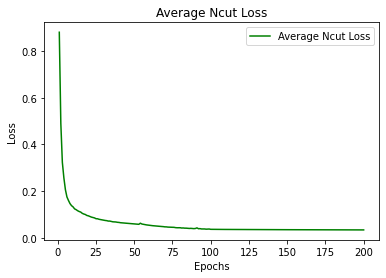

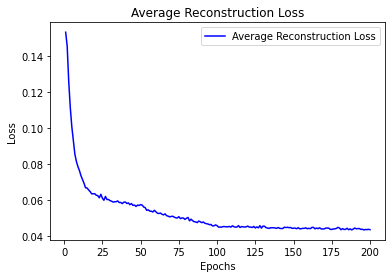

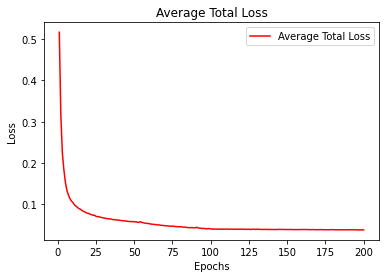

In [109]:
###################################
#          Optimisation           #
###################################
optimizer = torch.optim.SGD(params = model.parameters(), lr = init_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = lr_decay_iter, gamma = lr_decay) # dynamic learning rate schedular

###################################
#          Loss Criterion         #
###################################

Ncuts = NCutsLoss()
def reconstruction_loss(x, x_prime):
  criterionIdt = torch.nn.MSELoss()
  rec_loss = criterionIdt(x_prime, x)
  return rec_loss


avg_loss_vals=  []
avg_ncut_loss_vals=  []
avg_recon_loss_vals=  []

###################################
#         Iterate Epoches         #
###################################
for epoch in range(max_iter):

  print("Epoch: " + str(epoch+1))
  scheduler.step() # change the learning rate in a step
  avg_ncut_loss = 0.0
  avg_recon_loss = 0.0
  avg_loss = 0.0
  t_load = 0.0
  t_forward = 0.0
  t_loss = 0.0
  t_backward = 0.0
  t_adjust = 0.0
  t_reset = 0.0
  t_inloss = 0.0

  ###################################
  #         Iterate Batches         #
  ###################################
  for step,[x,w,gt,n] in enumerate(dataloader): # number of iterations = 12
  
    x = x.cuda() # (6, 3, 224, 224)
    w = w.cuda() # (6, 1, 224, 224, 7, 7)
    sw = w.sum(-1).sum(-1) # (6, 1, 224, 224)
    
    optimizer.zero_grad()

    pred, x_prime = model(x)
    pad = nn.ConstantPad2d(padding=3,value=0)
    pad_pred = pad(pred)

    ###################################
    #          N-Cut Loss             #
    ###################################
    ncuts_loss = Ncuts(pred,pad_pred,w,sw)
    ncuts_loss = ncuts_loss.sum()/BatchSize 
    avg_ncut_loss = (avg_ncut_loss * step + ncuts_loss.item())/(step+1) 

    ###################################
    #       Reconstruction Loss       #
    ###################################
    recon_loss = reconstruction_loss(x, x_prime)
    avg_recon_loss = (avg_recon_loss * step + recon_loss.item())/(step+1) 

    ###################################
    #          Total Loss             #
    ###################################
    loss = (ncuts_loss + recon_loss)/2
    avg_loss = (avg_loss * step + loss.item())/(step+1) 

    loss.backward()
    optimizer.step()

  avg_loss_vals.append(avg_loss)
  avg_ncut_loss_vals.append(avg_ncut_loss)
  avg_recon_loss_vals.append(avg_recon_loss)

epochs = range(1, max_iter + 1)
plt.plot(epochs, avg_ncut_loss_vals, 'g', label='Average Ncut Loss')
plt.title('Average Ncut Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

epochs = range(1, max_iter + 1)
plt.plot(epochs, avg_recon_loss_vals, 'b', label='Average Reconstruction Loss')
plt.title('Average Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

epochs = range(1, max_iter + 1)
plt.plot(epochs, avg_loss_vals, 'r', label='Average Total Loss')
plt.title('Average Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

###################################
#          Save Model             #
###################################
torch.save(model.state_dict(), '/content/model.pth')


## 3.7&nbsp;Evaluation

Jaccard Index = $\frac{TP}{TP+FP+FN}$

Pixel Accuracy = $\frac{TP+TN}{TP+TN+FP+FN}$

In [ ]:
def jaccard_index(y_true, y_pred):
  y_true_f = y_true.flatten()
  y_pred_f = y_pred.flatten()
  intersection = np.sum(y_true_f * y_pred_f)
  union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
  
  return intersection / union

def accuracy(y_true, y_pred):
  y_true_f = y_true.flatten()
  y_pred_f = y_pred.flatten()
  score = accuracy_score(y_true_f, y_pred_f)

  return score

In [ ]:
import numpy as np
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as util
from pydensecrf.utils import unary_from_softmax

MAX_ITER = 20

POS_W = 2
POS_XY_STD = 5

Bi_W = 2
Bi_XY_STD = 5
Bi_RGB_STD = 10

def dense_crf(img, output_probs):
  # Channels
  ch = output_probs.shape[0]
  # Height
  height = output_probs.shape[1]
  # Width
  width = output_probs.shape[2]

  d = dcrf.DenseCRF2D(width, height, ch)

  ###################################
  #          Unary Potential        #
  ###################################
  U = unary_from_softmax(output_probs) # -log(prob)
  U = np.ascontiguousarray(U)
  d.setUnaryEnergy(U)

  ###################################
  #        Pair-Wise Potential      #
  ###################################
  img = np.ascontiguousarray(img)
  # smoothness kernel(spatial)
  d.addPairwiseGaussian(sxy = POS_XY_STD, compat = POS_W)
  # appearance kernel (bilateral)
  d.addPairwiseBilateral(sxy = Bi_XY_STD, srgb = Bi_RGB_STD, rgbim = img, compat = Bi_W)

  Q = d.inference(MAX_ITER)
  Q = np.array(Q).reshape((ch, height, width))
  return Q

In [114]:
color_lib = [( 255, 255, 255), ( 0, 0, 0)]
# color_lib = [( 0, 0, 0), ( 255, 255, 255)]
train_scores_df = pd.DataFrame(columns = ['File', 'Jaccard Index(IoU)', 'Pixel Accuracy'])

###################################
#          Load Data              #
###################################
dataset_test = DataLoader(datapath = '/content/data/', mode = 'train')
dataloader_test = dataset_test.torch_loader()

###################################
#          Load Model             #
###################################
model = torch.nn.DataParallel(WNet())
model.load_state_dict(torch.load('/content/model.pth'))
model.eval()

for step,[x, w, gt,n] in enumerate(dataloader_test):       
    x = x.cuda() # move tensor from the cpu to gpu
    pred, x_prime = model(x) 
    """
    x = (6, 3, 224, 224)
    seg = (6, 2, 224, 224)
    x_prime = (6, 3, 224, 224)
    """
    output_probs = pred.cpu().detach().numpy()
    seg = (pred.argmax(dim = 1)).cpu().detach().numpy() # seg = (6, 224, 224)
    x = x.cpu().detach().numpy()*255 
    """
    move tensor from gpu to cpu
    detach the tensor from the computational graph :: avoid gradient calculation
    x = (6, 3, 224, 224)
    """
    x = np.transpose(x.astype(np.uint8),(0,2,3,1)) # x = (6, 224, 224, 3)

    color_map = lambda c: color_lib[c]
    cmap = np.vectorize(pyfunc = color_map)
    seg = np.moveaxis(a = np.array(cmap(seg)), source = 0, destination = -1).astype(np.uint8)
    """
    np.array(cmap(seg)) = (3, 6, 224, 224)
    seg = (6, 224, 224, 3)
    """

    gt = gt.cpu().detach().numpy()*255 
    for i in range(seg.shape[0]):

        original = x[i]
        gt_image = gt[i,:,:,:]
        index = int(n[i].item()) # tensor >> integer

        ###################################
        #        Post Processing          #
        ###################################
        segmented = output_probs[i,:,:,:]
        # segmented_crf = dense_crf(original, segmented)
        segmented = np.argmax(segmented, axis=0)
        segmented = np.moveaxis(a = np.array(cmap(segmented)), source = 0, destination = -1).astype(np.uint8)

        # ###################################
        # #          Original               #
        # ###################################
        # plt.figure()
        # plt.title('Original Image')
        # plt.imshow(original)
        # plt.show()
        cv2.imwrite('/content/results/train/original/original_image_'+str(index)+'.jpg',original)

        # ###################################
        # #          Segmented              #
        # ###################################
        # plt.figure()
        # plt.title('Segmented Image')
        # plt.imshow(segmented)
        # plt.show()
        cv2.imwrite('/content/results/train/predicted/predicted_image_'+str(index)+'.jpg',segmented)

        # ###################################
        # #          Ground Truth           #
        # ###################################
        # plt.figure()
        # plt.title('Ground Truth Image')
        # plt.imshow(gt_image)
        # plt.show()

        # ###################################
        # #          Reconstructed          #
        # ###################################
        reconstructed = x_prime[i].cpu().detach().numpy()*255
        red_normalised = cum_cnt_cut_norm(reconstructed[0])
        green_normalised = cum_cnt_cut_norm(reconstructed[1])
        blue_normalised = cum_cnt_cut_norm(reconstructed[2])

        reconstructed = np.dstack((red_normalised, green_normalised, blue_normalised))
        # plt.figure()
        # plt.title('Reconstructed Image With Cumulative Count Cut')
        # plt.imshow(reconstructed)
        # plt.show()
        cv2.imwrite('/content/results/train/reconstructed/reconstructed_image_'+str(index)+'.jpg',reconstructed)

        ###################################
        #          Evaluation             #
        ###################################
        ground_truth = (gt_image[:,:,0]/np.max(gt_image[:,:,0])).astype(int)
        predicted = (segmented[:,:,0]/np.max(segmented[:,:,0])).astype(int)
        iou = jaccard_index(ground_truth, predicted)
        acc = accuracy(ground_truth, predicted)

        indices = {'File':index,
                   'Jaccard Index(IoU)': iou,
                   'Pixel Accuracy':acc}
        train_scores_df = train_scores_df.append(indices, ignore_index = True)

train_scores_df = train_scores_df.sort_values(by = ['File'])
train_scores_df.to_csv('/content/results/train/train_scores.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
calculating weights.
weight calculated.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Step1


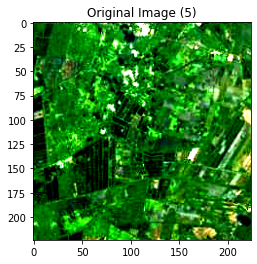

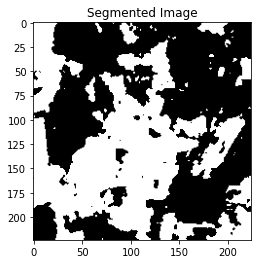

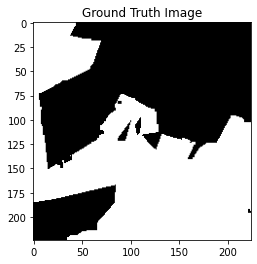

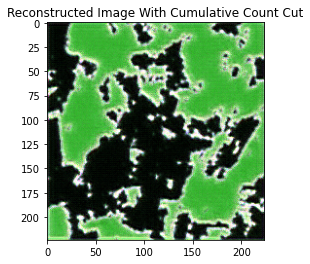

Jaccard Index : 0.49680913986862996
Pixel Accuracy : 0.6778539540816326




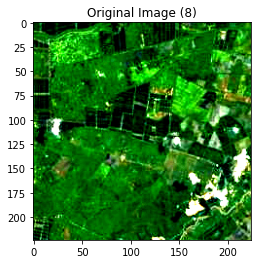

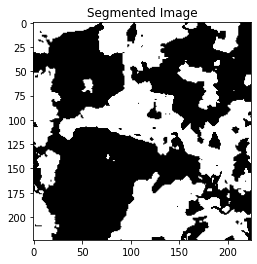

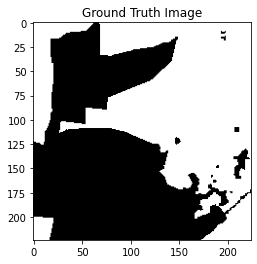

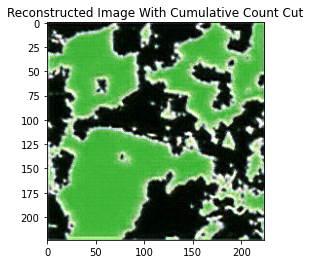

Jaccard Index : 0.4715127701375246
Pixel Accuracy : 0.6568877551020408




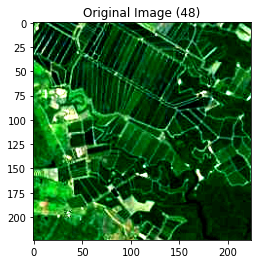

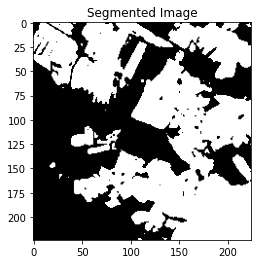

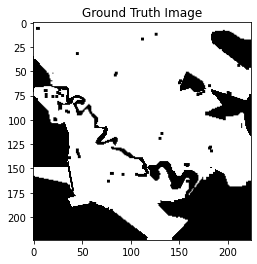

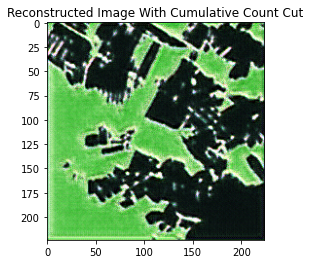

Jaccard Index : 0.4435082708556468
Pixel Accuracy : 0.5340202487244898




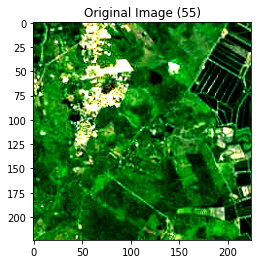

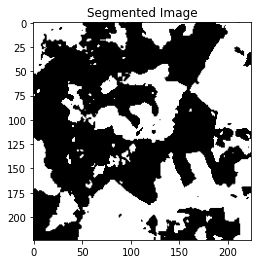

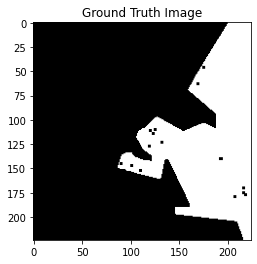

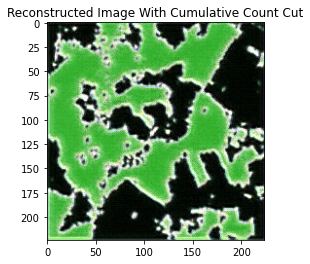

Jaccard Index : 0.3236772630284619
Pixel Accuracy : 0.6272919323979592




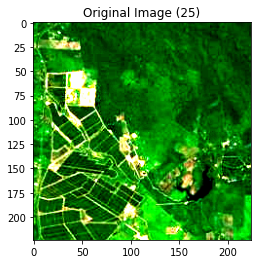

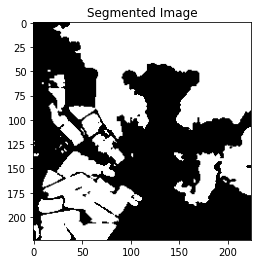

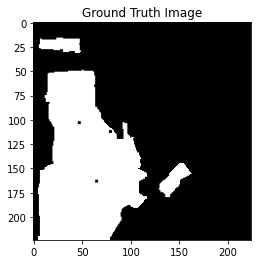

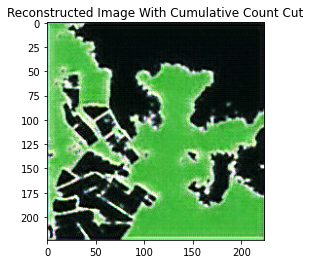

Jaccard Index : 0.24391329222554192
Pixel Accuracy : 0.5259088010204082




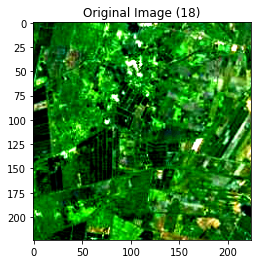

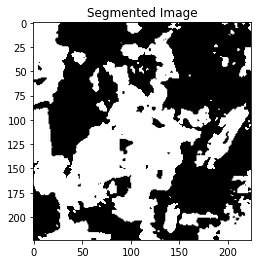

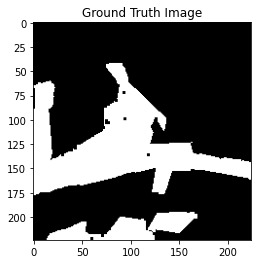

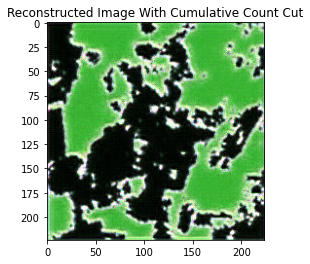

Jaccard Index : 0.413425514657603
Pixel Accuracy : 0.6973254145408163


Step2


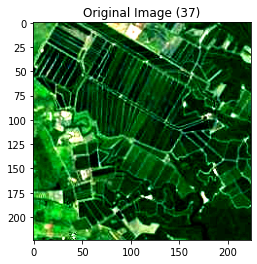

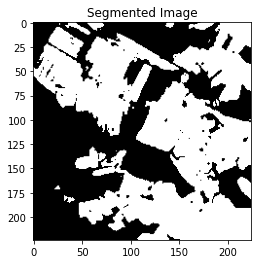

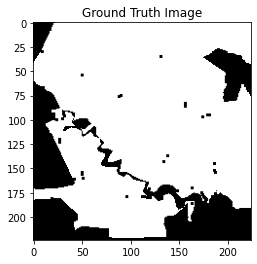

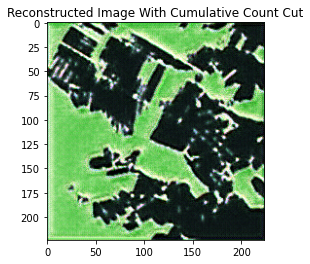

Jaccard Index : 0.48666499074433806
Pixel Accuracy : 0.5523357780612245




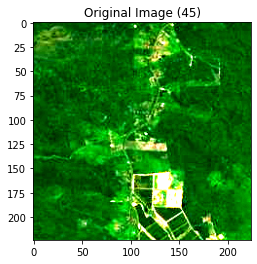

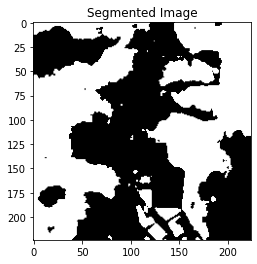

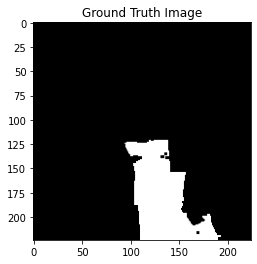

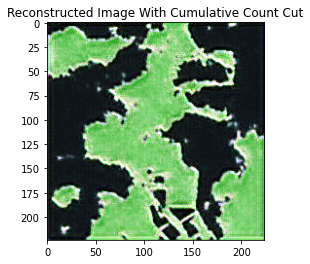

Jaccard Index : 0.04665587918015102
Pixel Accuracy : 0.43638392857142855




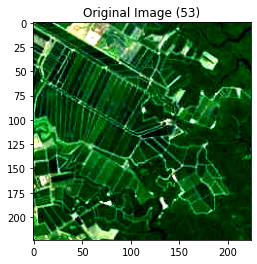

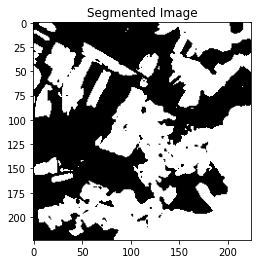

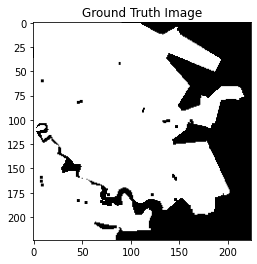

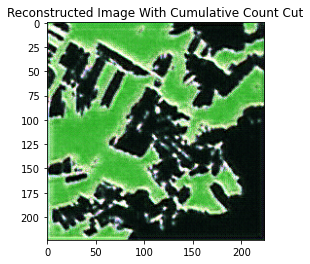

Jaccard Index : 0.2986737850091098
Pixel Accuracy : 0.34024234693877553




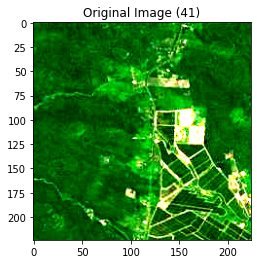

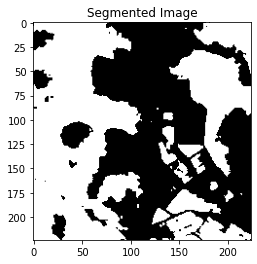

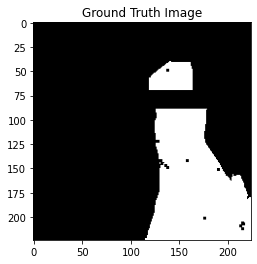

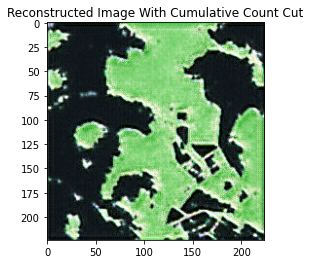

Jaccard Index : 0.12033021266413424
Pixel Accuracy : 0.41386320153061223




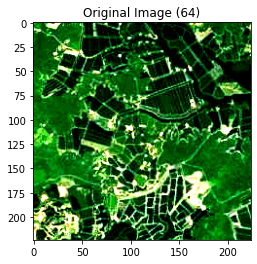

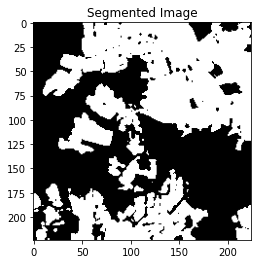

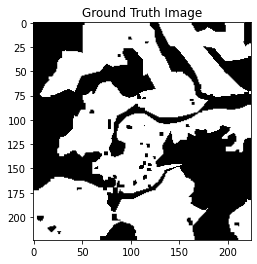

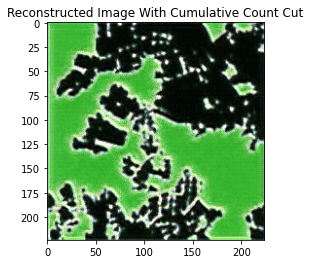

Jaccard Index : 0.6031498425078746
Pixel Accuracy : 0.7363480548469388




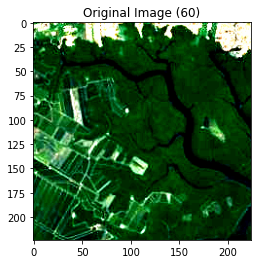

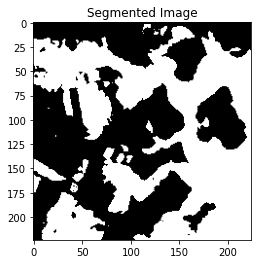

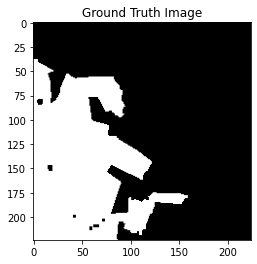

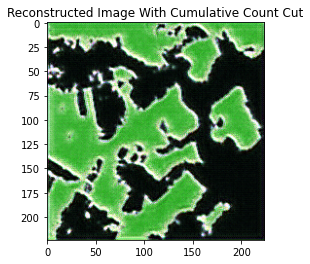

Jaccard Index : 0.14917640433619597
Pixel Accuracy : 0.3977798150510204


Step3


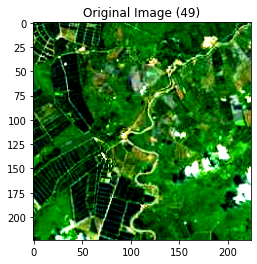

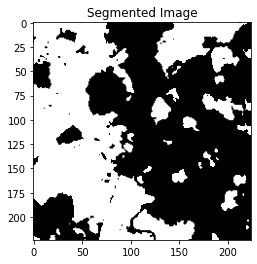

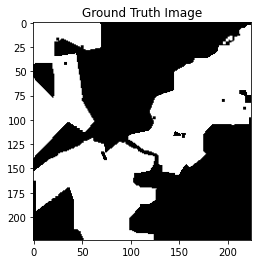

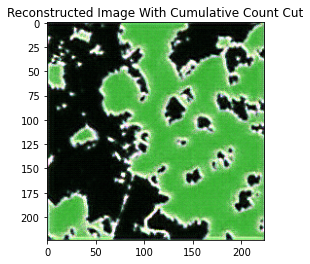

Jaccard Index : 0.44510833674014905
Pixel Accuracy : 0.6483378507653061




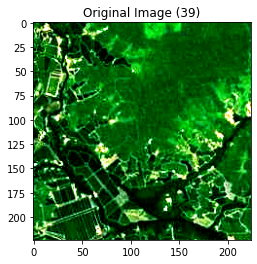

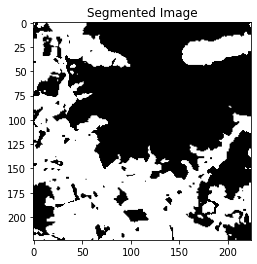

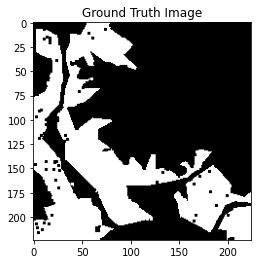

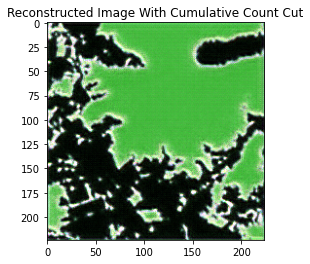

Jaccard Index : 0.443971026842778
Pixel Accuracy : 0.6878985969387755




In [115]:
color_lib = [( 255, 255, 255), ( 0, 0, 0)]
# color_lib = [( 0, 0, 0), ( 255, 255, 255)]

test_scores_df = pd.DataFrame(columns = ['File', 'Jaccard Index(IoU)', 'Pixel Accuracy'])

###################################
#          Load Data              #
###################################
dataset_test = DataLoader(datapath = '/content/data/', mode = 'test')
dataloader_test = dataset_test.torch_loader()

###################################
#          Load Model             #
###################################
model = torch.nn.DataParallel(WNet())
model.load_state_dict(torch.load('/content/model.pth'))
model.eval()

for step,[x, gt,n] in enumerate(dataloader_test):
    print('Step' + str(step+1))         
    x = x.cuda() # move tensor from the cpu to gpu
    pred, x_prime = model(x) 
    """
    x = (6, 3, 224, 224)
    seg = (6, 2, 224, 224)
    x_prime = (6, 3, 224, 224)
    """
    output_probs = pred.cpu().detach().numpy()
    seg = (pred.argmax(dim = 1)).cpu().detach().numpy() # seg = (6, 224, 224)
    x = x.cpu().detach().numpy()*255 
    """
    move tensor from gpu to cpu
    detach the tensor from the computational graph :: avoid gradient calculation
    x = (6, 3, 224, 224)
    """
    x = np.transpose(x.astype(np.uint8),(0,2,3,1)) # x = (6, 224, 224, 3)

    color_map = lambda c: color_lib[c]
    cmap = np.vectorize(pyfunc = color_map)
    seg = np.moveaxis(a = np.array(cmap(seg)), source = 0, destination = -1).astype(np.uint8)
    """
    np.array(cmap(seg)) = (3, 6, 224, 224)
    seg = (6, 224, 224, 3)
    """

    gt = gt.cpu().detach().numpy()*255 
    for i in range(seg.shape[0]):

        original = x[i]
        gt_image = gt[i,:,:,:]
        index = int(n[i].item()) # tensor >> integer

        ###################################
        #        Post Processing          #
        ###################################
        segmented = output_probs[i,:,:,:]
        # segmented_crf = dense_crf(original, segmented)
        segmented = np.argmax(segmented, axis=0)
        segmented = np.moveaxis(a = np.array(cmap(segmented)), source = 0, destination = -1).astype(np.uint8)

        ###################################
        #          Original               #
        ###################################
        plt.figure()
        plt.title('Original Image '+'('+str(index)+')')
        plt.imshow(original)
        plt.show()
        cv2.imwrite('/content/results/test/original/original_image_'+str(index)+'.jpg',original)

        ###################################
        #          Segmented              #
        ###################################
        plt.figure()
        plt.title('Segmented Image')
        plt.imshow(segmented)
        plt.show()
        cv2.imwrite('/content/results/test/predicted/predicted_image_'+str(index)+'.jpg',segmented)

        ###################################
        #          Ground Truth           #
        ###################################
        plt.figure()
        plt.title('Ground Truth Image')
        plt.imshow(gt_image)
        plt.show()

        ###################################
        #          Reconstructed          #
        ###################################
        reconstructed = x_prime[i].cpu().detach().numpy()*255
        red_normalised = cum_cnt_cut_norm(reconstructed[0])
        green_normalised = cum_cnt_cut_norm(reconstructed[1])
        blue_normalised = cum_cnt_cut_norm(reconstructed[2])

        rgb_values = np.dstack((red_normalised, green_normalised, blue_normalised))
        plt.figure()
        plt.title('Reconstructed Image With Cumulative Count Cut')
        plt.imshow(rgb_values)
        plt.show()
        cv2.imwrite('/content/results/test/reconstructed/reconstructed_image_'+str(index)+'.jpg',segmented)

        ###################################
        #          Evaluation             #
        ###################################
        ground_truth = (gt_image[:,:,0]/np.max(gt_image[:,:,0])).astype(int)
        predicted = (segmented[:,:,0]/np.max(segmented[:,:,0])).astype(int)
        # predicted = (seg[i,:,:,0]/np.max(seg[i,:,:,0])).astype(int)
        iou = jaccard_index(ground_truth, predicted)
        acc = accuracy(ground_truth, predicted)
        print(f'Jaccard Index : {iou}')
        print(f'Pixel Accuracy : {acc}\n\n')

        indices = {'File':index,
                   'Jaccard Index(IoU)': iou,
                   'Pixel Accuracy':acc}
        test_scores_df = test_scores_df.append(indices, ignore_index = True)

test_scores_df = test_scores_df.sort_values(by = ['File'])
test_scores_df.to_csv('/content/results/test/test_scores.csv')

In [116]:
from google.colab import files
!zip -r /content/results.zip /content/results
files.download("/content/results.zip")

  adding: content/results/ (stored 0%)
  adding: content/results/test/ (stored 0%)
  adding: content/results/test/predicted/ (stored 0%)
  adding: content/results/test/predicted/predicted_image_39.jpg (deflated 5%)
  adding: content/results/test/predicted/predicted_image_41.jpg (deflated 5%)
  adding: content/results/test/predicted/predicted_image_25.jpg (deflated 5%)
  adding: content/results/test/predicted/predicted_image_49.jpg (deflated 4%)
  adding: content/results/test/predicted/predicted_image_18.jpg (deflated 4%)
  adding: content/results/test/predicted/predicted_image_55.jpg (deflated 4%)
  adding: content/results/test/predicted/predicted_image_53.jpg (deflated 5%)
  adding: content/results/test/predicted/predicted_image_37.jpg (deflated 5%)
  adding: content/results/test/predicted/predicted_image_64.jpg (deflated 4%)
  adding: content/results/test/predicted/predicted_image_5.jpg (deflated 4%)
  adding: content/results/test/predicted/predicted_image_48.jpg (deflated 5%)
  addi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5&nbsp;$\color{Blue}{\text{References}}$
(1) https://www.kaggle.com/competitions/dstl-satellite-imagery-feature-detection/data

(2) https://aswali.github.io/WNet/

(3) https://github.com/gr-b/W-Net-Pytorch

(4) https://www.geeksforgeeks.org/tensor-detach-method-in-python-pytorch/

(5) https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html

(6) https://holypython.com/python-pil-tutorial/how-to-adjust-brightness-contrast-sharpness-and-saturation-of-images-in-python-pil/

(7) https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html

(8) https://www.youtube.com/watch?v=KOF38xAvo8I

(9) https://github.com/lucasb-eyer/pydensecrf

(10) https://koushik1102.medium.com/transfer-learning-with-vgg16-and-vgg19-the-simpler-way-ad4eec1e2997